## submit jobs to cluster

In [2]:
import os
from rosemary import jpt_in_notebook, jpt_setup; jpt_setup()
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

first_N = None
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

####
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; normalize_embeddings = True

dataset = 'wizardlm'
## 
clustering_fn_list = []
# clustering_fn_list += [
#     f'cl=kmeans_nc={n_clusters}' for n_clusters in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ]
clustering_fn_list = [
    f'cl=kmeans_nc={n_clusters}'
]

# first_N = 10_000
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz=256'


###

cmds = []
for clustering_fn in clustering_fn_list:
    save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
                f"clustering/{encode_fn_type+'/' if encode_fn_type!='sft' else ''}{model_name}/"
                f"{dataset+'(N='+str(first_N)+')' if first_N else dataset}/{clustering_fn}")

    cmd = f"""
    python note_pruning_clustering.py \
        --model_name {model_name} \
        --dataset {dataset} \
        --encode_fn_type {encode_fn_type} \
        --clustering_fn {clustering_fn} \
        {'--normalize_embeddings' if normalize_embeddings else ''} \
        {'--first_N '+str(first_N) if first_N else ''} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'cluster.{dataset}.{clustering_fn}', 
        nodes=1,
        num_cpus=64,
        cpu_mem=128,
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    cmds.append(cmd)
    
print(f'#cmds: {len(cmds)}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Submiting job with:
{
    "job_name": "cluster.wizardlm.cl=kmeans_nc=100",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=100 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_nc=100

Submiting job with:
{
    "job_name": "cluster.wizardlm.cl=kmeans_nc=200",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=200 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/

In [8]:

with open('note_pruning_cluster_test.sh', 'w') as f:
    f.write('\n'.join(['CUDA_VISIBLE_DEVICES=1 '+x for x in cmds]))
    
    

## analyze clustering results

In [3]:
save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
            f"clustering/{encode_fn_type+'/' if encode_fn_type!='sft' else ''}{model_name}/"
            f"{dataset+'(N='+str(first_N)+')' if first_N else dataset}/{clustering_fn}")

In [153]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from note_pruning_analysis import get_clustering_results, flatten_dict

dataset='wizardlm'
model_name='all-mpnet-base-v2'
encode_fn_type = 'input'

# clustering_fn_list = [
#     f'cl=kmeans_nc={x}' for x in np.arange(100,1100,100)
# ]

clustering_fn_list = os.listdir(os.path.join('clustering', encode_fn_type, model_name, dataset))
clustering_fn_list = [x for x in clustering_fn_list if 'nc=200' in x]


data = []
for clustering_fn in clustering_fn_list:
    d = get_clustering_results(dataset, model_name, clustering_fn, encode_fn_type='input', return_data=False)
    d = flatten_dict(d['info'])
    for k in list(d.keys()):
        d[k.split('scores_')[-1]] = d.pop(k)
    d = {'n_clusters': re.search(r'nc=([^_]+)', d['clustering_fn']).group(1),
         **d}
    # d.pop('clustering_fn')
    d['cluster_sizes_min'] = int(np.min(d['cluster_sizes']))
    d['cluster_sizes_mean'] = int(np.mean(d['cluster_sizes']))
    d['cluster_sizes_max'] = int(np.max(d['cluster_sizes']))
    data.append(d)
    
df = pd.DataFrame(data)
df = df.drop(columns=['N', 'model_name', 'dataset', 'encode_fn_type', 'cluster_sizes'])

higher_is_better = [
    ('inertia', False),
    ('silhouette_score_cd', True),
    ('silhouette_score_l2', True),
    ('variance_ratio', True),
    ('davies_bouldin_index', False),
]

df = df.rename(columns={k: k+('$\\uparrow$' if v else '$\\downarrow$') for k, v in higher_is_better})
df = df.round(3)
df

,n_clusters,clustering_fn,time_elapsed,inertia$\downarrow$,silhouette_score_cd$\uparrow$,silhouette_score_l2$\uparrow$,variance_ratio$\uparrow$,davies_bouldin_index$\downarrow$,cluster_sizes_min,cluster_sizes_mean,cluster_sizes_max
0,200,cl=kmeans_nc=200,118.462,97995.406,0.053,0.029,231.343,3.801,240,715,2214
1,200,cl=kmeansminibatch_nc=200_bsz=4096,26.996,98961.570,0.044,0.024,222.895,4.089,8,715,2015
2,200,cl=kmeansminibatch_nc=200_bsz=1024,42.962,99405.234,0.045,0.025,219.192,3.913,1,715,2052
3,200,cl=kmeansminibatch_nc=200_bsz=2048,29.268,99377.891,0.047,0.026,219.304,4.000,1,715,1785
4,200,cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_...,102.299,97995.430,0.053,0.029,231.343,3.801,240,715,2214
5,200,cl=kmeansminibatch_nc=200_bsz=256,73.982,102598.000,0.037,0.020,191.181,3.419,1,715,3634


In [141]:


xs = df['clustering_fn'].apply(lambda x: int(x.split('nc=')[-1]))
ys = df['scores_inertia'].to_numpy()
plt.plot(xs, ys)

# ys = df['scores_silhouette_score_cd'].to_numpy()
# plt.plot(xs, ys)
# ys = df['scores_silhouette_score_l2'].to_numpy()
# plt.plot(xs, ys)


ValueError: invalid literal for int() with base 10: '200_bsz=1024'

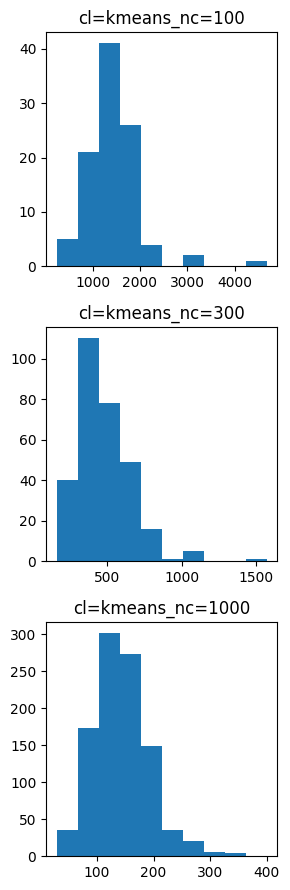

In [8]:
ys_list = df['cluster_sizes'].tolist()
N = len(ys_list)

fig, axs = plt.subplots(N,1,figsize=(3,3*N), sharex=False)
for i in range(N):
    ys = ys_list[i]
    ax = axs[i]
    ax.hist(ys)
    ax.set_title(df.iloc[i]['clustering_fn'])
fig.tight_layout()

## clustering code base


In [129]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
# !nvidia-smi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import re
import argparse
import json
import pickle
import string
import time
import matplotlib.pyplot as plt

import numpy as np
import scipy
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans, AgglomerativeClustering
import torch
from tqdm import tqdm
import pandas as pd

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

import time
from note_pruning_analysis import (
    get_lm_output,
    get_dataset,
)
from note_pruning_clustering import (
    pairwise_cosine_distance,
    clustering_sort_by_cluster_size,
    clustering_algorithm_scores,
    clustering_dist_to_centroids,
    clustering_knn_withincluster,
    clustering_run,
    clustering_compute_and_save_results,
)


In [148]:
model_name = 'all-mpnet-base-v2'

dataset = 'wizardlm'
encode_fn_type = 'input'
# first_N = 10_000
first_N = None

n_clusters = 200
clustering_fn = f'cl=kmeans_nc={n_clusters}'
bsz = 4096
clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz={bsz}'

In [149]:
save_dir = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn+'_test')
os.makedirs(save_dir, exist_ok=True)
save_dir

'clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeansminibatch_nc=200_bsz=4096_test'

In [150]:

ds = get_dataset(dataset, processed=True)
if encode_fn_type == 'input':
    def get_user_prompt_fn(example):
        example['text'] = example['messages'][0]['content']
        return example
    ds = ds.map(get_user_prompt_fn, num_proc=16)

ds

Dataset({
    features: ['dataset', 'id', 'messages', 'text'],
    num_rows: 143000
})

In [151]:
d = get_lm_output(dataset, 
                  model_name, 
                  encode_fn_type=encode_fn_type,
                  return_text_embedding=True,)
X = d['text_embedding']
X = X / np.linalg.norm(X, axis=-1, keepdims=True)

if first_N:
    ds = ds.select(range(first_N))
    X = X[:first_N]

ModuleNotFoundError: No module named 'faiss'

In [152]:

info = {}
info['N'] = len(X)
info['dataset'] = 'dataset'
info['model_name'] = model_name
info['encode_fn_type'] = encode_fn_type
info['clustering_fn'] = clustering_fn

t0 = time.time()
Y, C, clustering_model = clustering_run(clustering_fn, X)
info['time_elapsed'] = time.time()-t0
info['scores'] = {}
info['scores'].update({'inertia': clustering_model.inertia_})
info['scores'].update(clustering_algorithm_scores(X, Y))
info['cluster_sizes'] = np.unique(Y, return_counts=True)[1].tolist()

with open(os.path.join(save_dir, 'info.json'), 'w') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)

clustering_compute_and_save_results(X, Y, C, ds=ds, save_dir=save_dir)

Init 1/1 with method k-means++
Inertia for init 1/1: 14025.115234375
Minibatch step 1/3491: mean batch inertia: 1.1421377658843994
Minibatch step 2/3491: mean batch inertia: 0.7525666356086731, ewa inertia: 0.7525666356086731
Minibatch step 3/3491: mean batch inertia: 0.7268795371055603, ewa inertia: 0.7510951164519014
Minibatch step 4/3491: mean batch inertia: 0.7230073809623718, ewa inertia: 0.7494860736540871
Minibatch step 5/3491: mean batch inertia: 0.7188764810562134, ewa inertia: 0.7477325629614222
Minibatch step 6/3491: mean batch inertia: 0.7076785564422607, ewa inertia: 0.7454380166197535
Minibatch step 7/3491: mean batch inertia: 0.7084162831306458, ewa inertia: 0.7433171780190251
Minibatch step 8/3491: mean batch inertia: 0.7060450315475464, ewa inertia: 0.7411819941818887
Minibatch step 9/3491: mean batch inertia: 0.7091067433357239, ewa inertia: 0.7393445213325256
Minibatch step 10/3491: mean batch inertia: 0.7023130655288696, ewa inertia: 0.7372231257762459
Minibatch ste

Minibatch step 87/3491: mean batch inertia: 0.6912763714790344, ewa inertia: 0.6945901522796577
Minibatch step 88/3491: mean batch inertia: 0.6915791034698486, ewa inertia: 0.6944176603960348
Minibatch step 89/3491: mean batch inertia: 0.6904850602149963, ewa inertia: 0.6941923762324061
Minibatch step 90/3491: mean batch inertia: 0.6926165223121643, ewa inertia: 0.6941021013719882
Minibatch step 91/3491: mean batch inertia: 0.6948202252388, ewa inertia: 0.6941432400403675
Minibatch step 92/3491: mean batch inertia: 0.6919127106666565, ewa inertia: 0.6940154612372162
Minibatch step 93/3491: mean batch inertia: 0.6934134364128113, ewa inertia: 0.6939809734548823
Minibatch step 94/3491: mean batch inertia: 0.6913915276527405, ewa inertia: 0.6938326336529848
Minibatch step 95/3491: mean batch inertia: 0.6938083171844482, ewa inertia: 0.6938312406521648
Minibatch step 96/3491: mean batch inertia: 0.6920304298400879, ewa inertia: 0.693728078840901
Minibatch step 97/3491: mean batch inertia: 

Minibatch step 174/3491: mean batch inertia: 0.6880269050598145, ewa inertia: 0.6921052632040468
Minibatch step 175/3491: mean batch inertia: 0.6949023604393005, ewa inertia: 0.6922654985908706
Minibatch step 176/3491: mean batch inertia: 0.692624568939209, ewa inertia: 0.6922860684071207
Minibatch step 177/3491: mean batch inertia: 0.6893940567970276, ewa inertia: 0.6921203957257417
Minibatch step 178/3491: mean batch inertia: 0.68760746717453, ewa inertia: 0.6918618666896403
Minibatch step 179/3491: mean batch inertia: 0.6919243335723877, ewa inertia: 0.6918654451870176
Minibatch step 180/3491: mean batch inertia: 0.6941722631454468, ewa inertia: 0.6919975942818873
Minibatch step 181/3491: mean batch inertia: 0.6878479719161987, ewa inertia: 0.6917598777175296
Minibatch step 182/3491: mean batch inertia: 0.6947809457778931, ewa inertia: 0.6919329435670726
Minibatch step 183/3491: mean batch inertia: 0.6910033226013184, ewa inertia: 0.6918796890097516
Minibatch step 184/3491: mean bat

Minibatch step 259/3491: mean batch inertia: 0.6922931671142578, ewa inertia: 0.6923937790994189
Minibatch step 260/3491: mean batch inertia: 0.6939639449119568, ewa inertia: 0.6924837281091203
Minibatch step 261/3491: mean batch inertia: 0.6908196806907654, ewa inertia: 0.6923884009683928
Minibatch step 262/3491: mean batch inertia: 0.6929015517234802, ewa inertia: 0.6924177974830024
Minibatch step 263/3491: mean batch inertia: 0.6930539608001709, ewa inertia: 0.6924542409337071
Minibatch step 264/3491: mean batch inertia: 0.6913280487060547, ewa inertia: 0.6923897255336126
Minibatch step 265/3491: mean batch inertia: 0.6918649673461914, ewa inertia: 0.6923596640720049
Minibatch step 266/3491: mean batch inertia: 0.6938378810882568, ewa inertia: 0.6924443456742114
Minibatch step 267/3491: mean batch inertia: 0.6935673952102661, ewa inertia: 0.6925086810410924
Minibatch step 268/3491: mean batch inertia: 0.6912686228752136, ewa inertia: 0.6924376426812566
Minibatch step 269/3491: mean 